This notebook computes the infinite-width GP kernel for a Transformer.
The code runs as is, and we summarize the derivation of the kernel in markdown cells, but the reader should take a look at the derivation in the paper to get the full picture.
We recommend the reader to have gone through [the RNN notebook](RNN.ipynb) first.

In [1]:
import numpy as np
import scipy as sp
from numpy import asarray as npa
import numbers
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

In [2]:
from transformer_sim import Transformer
from transformer_theory import th_trsfmr

Load the GloVe vectors and their covariances that we have saved.
They were generated from the two sentences

```The brown fox jumps over the dog.```

```The quick brown fox jumps over the lazy dog.```

Concretely, `exampleGloveVecs[:7]` contains the GloVe embeddings of the first sentence, and `exampleGloveVecs[7:16]` contains those of the second sentence.

Likewise, `exampleGloveCov` is a 16x16 matrix, such that `exampleGloveCov[:7, :7]` gives the autocovariance of the GloVe embeddings of the first sentence, `exampleGloveCov[7:, 7:]` gives that of the second sentence, and `exampleGloveCov[:7, 7:]` gives the covariance between those of the first and those of the second sentence.

In [3]:
sent1 = "The brown fox jumps over the dog".split()
sent2 = "The quick brown fox jumps over the lazy dog".split()

In [4]:
with open('ExampleGloVeVecs.npy', 'rb') as f:
    exampleGloveVecs = np.load(f)
with open('ExampleGloVeCov.npy', 'rb') as f:
    exampleGloveCov = np.load(f)

Here's what the GloVe embedding kernel matrix looks like

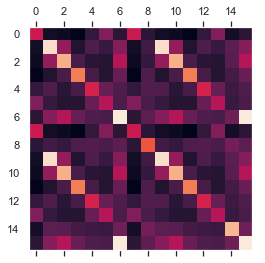

In [5]:
plt.matshow(exampleGloveCov)
plt.grid()

# Self-Attention / Transformers

$\newcommand{\MaskedAttention}{\mathrm{MaskedAttention}}
\newcommand{\SoftMax}{\mathrm{SoftMax}}
\newcommand{\Layernorm}{\mathrm{Layernorm}}
\newcommand{\trsp}{\top}$
$\newcommand{\R}{\mathbb R}
\newcommand{\EV}{\mathbb{E}}$
We'll work with the following transformer model.
Let $x^0_1, \ldots, x^0_t$ be a sequence of inputs.
Then each layer $l$ of our transformer works like the following
\begin{align*}
k^l_i &= U^l x_i^{l-1} \in \R^n\\
h^l_i &= \Layernorm(k^l_i + \MaskedAttention_i(k^l_i, \{k^l_j\}_{j=1}^t, \{k^l_j\}_{j=1}^t))\\
x^l_i &= \Layernorm(W^{l2}\mathrm{relu}(W^{l1}h^l_i + b^{l1})+ b^{l2} + h^l_i)
\end{align*}
where $U^l$, $W^{l1}, W^{l2}$ are weights and $b^{l1}, b^{l2}$ are the biases, and
$$\MaskedAttention_j(q, \{k^i\}_{i=1}^r, \{v^i\}_{i=1}^r)
= \sum_{i=1}^r a_i v^i, \qquad
a_i = \SoftMax(q^\trsp k^1/n, \ldots, q^\trsp k^j/n, -\infty, \ldots, -\infty)_i$$
for any $j \le r$.

There are several differences between this transformer and the standard version of [Vaswani et al. 2017](https://arxiv.org/abs/1706.03762):

- We are forgoing positional embeddings
- The keys, values, and queries here are the same, compared to the standard version, where they are different linear projections of $x^{l-1}_i$
- There is only 1 head, compared to the standard multi-head attention
- Our scaled attention is scaled by $n^{-1}$ instead of $n^{-1/2}$

The first three differences are just to simplify the presentation, but the last difference is fundamental.
As $n \to \infty$, $q^\trsp k/n$ will tend to a constant almost surely, but $q^\trsp k /\sqrt n$ will tend to either infinity (if $\lim_{n\to\infty} q^\trsp k/n \ne 0$) or a Gaussian variable (if $\lim_{n\to\infty} q^\trsp k/n = 0$).
In our case, since the keys and the queries are from the same collection, $q^\trsp k /n$ in general has a nonzero limit, so that $q^\trsp k /\sqrt n$ does not make sense here.


In code, this version of transformer looks like the following

In [6]:
import torch as th

def relu(c):
    return c * (c > 0)
    
class Transformer():
    def __init__(self, d, d_in, depth, temp=1, vw=1, vb=0):
        self.d = d
        self.depth = depth
        self.temp = temp
        self.vw = vw
        self.vb = vb
        self.W1s = [np.random.randn(d, d) * np.sqrt(vw/d) 
                   for _ in range(depth)]
        self.b1s = [np.random.randn(d) * np.sqrt(vb)
                    for _ in range(depth)]
        self.W2s = [np.random.randn(d, d) * np.sqrt(vw/d) 
                   for _ in range(depth)]
        self.b2s = [np.random.randn(d) * np.sqrt(vb)
                    for _ in range(depth)]
        self.embedding = np.random.randn(d_in, d) * np.sqrt(1/d_in)
        
    def __call__(self, seq):
        '''
        Input:
            seq: seqlen x tokensize array, for any seqlen and tokensize
        Output:
            out: seqlen x self.d_in array, for the same seqlen as input
        '''
        inseq = seq @ self.embedding
        for l in range(self.depth):
            # self attn
            gram = inseq @ inseq.T / inseq.shape[1]
            gram[np.triu_indices(gram.shape[0], 1)] = -np.inf
            weights = sp.special.softmax(gram / self.temp, axis=1)
            # weights @ inseq gives vectors returned by attention
            # inseq + weights @ inseq is the residual connection
            post_attn = self.layernorm(inseq + weights @ inseq)
            # self.post_attn = post_attn
            
            # FF
            inseq = relu(post_attn @ self.W1s[l] + self.b1s[l])
            inseq = inseq @ self.W2s[l] + self.b2s[l]
            inseq = self.layernorm(inseq + post_attn)
            
        return inseq
    def layernorm(self, seq):
        '''inplace layernorm
        Input:
            seq: seqlen x tokensize array, for any seqlen and tokensize
        Output:
            out: seqlen x tokensize array
                Means and standard deviation computed over the `tokensize` dimension
        '''
        seq -= np.mean(seq, axis=1, keepdims=True)
        seq /= np.std(seq, axis=1, keepdims=True)
        return seq
        
    def randomize(self, vw=None, vb=None):
        if vw is None:
            vw = self.vw
        if vb is None:
            vb = self.vb
        for p in self.W1s + self.W2s:
            # numpy has no way of sampling in place
            th.from_numpy(p).normal_(std=np.sqrt(vw / self.d))
        for p in self.b1s + self.b2s:
            th.from_numpy(p).normal_(std=np.sqrt(vb))

# Tensor Program Representation

Tensor program representation of a transformer computation at initialization, for one sequence

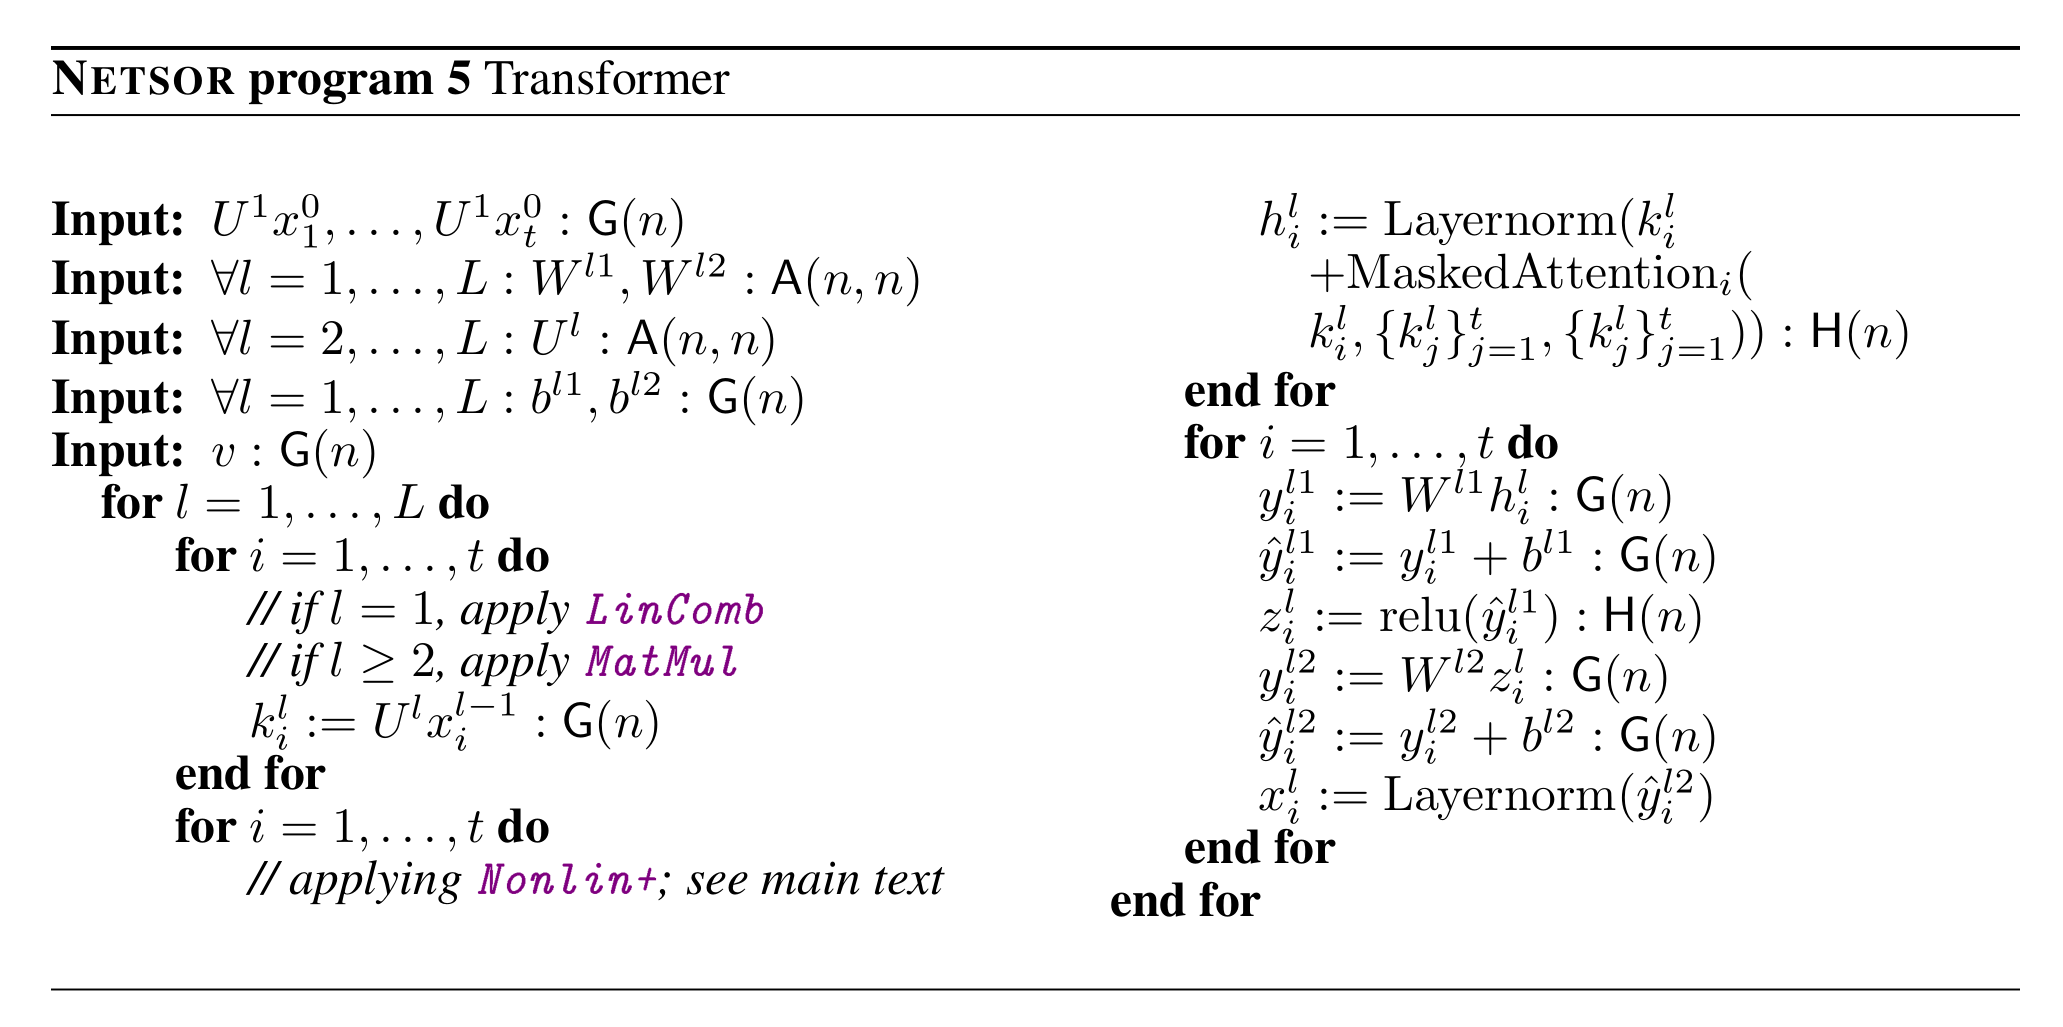

For multiple sequence it's similar.

# Theoretical Kernel

$\newcommand{\Gaus}{\mathcal{N}}$
For simplicity, assume for all $\alpha, \beta \in [n]$,

- $W^{l1}_{\alpha\beta}, W^{l2}_{\alpha\beta} \sim \Gaus(0, \sigma_w^2/n)$ for all $l \ge 1$
- $U^l_{\alpha\beta} \sim \Gaus(0, \sigma_u^2/n)$ for all $l \ge 2$ and $U^1_{\alpha\beta} \sim \Gaus(0, \sigma_u^2/m)$
- $b^{l1}_\alpha, b^{l2}_\alpha \sim \Gaus(0, \sigma_b^2)$ for all $l$

## Single Sequence

If we apply the NETSOR+ Master Theorem, then we will see the following:

Let $\Sigma^{l-1}$ be the normalized Gram matrix of $\{x^{l-1}_i\}_{i=1}^t$, $\Sigma^l_{ij} = x^l_i{}^\trsp x^l_j / n$.
Then the normalized Gram matrix $\hat \Sigma^l$ of $h^l_i$ at the infinite width limit can be computed as
\begin{align*}
\hat \Sigma^l = \hat D^{-1/2} (I + K) \Sigma^{l-1} (I + K)^\trsp \hat D^{-1/2}
\end{align*}
where 

- $K = \SoftMax(\bar \Sigma^{l-1})$, with SoftMax applied to each row, and $\bar \Sigma^{l-1}$ is the same as $\Sigma^{l-1}$, except that its upper triangular portion (above the diagonal) is all set to $-\infty$, and
- $\hat D$ is the diagonal matrix with diagonal equal to the diagonal of $(I + K) \Sigma^{l-1} (I + K)^\trsp$.

Here, $K$ is the attention weights, masked so that a token's embedding cannot depend on those of future tokens.
The identity matrix $I$ appears due to the skip connection.
And the multiplication by $\hat D^{-1/2}$ is as result of layernorm.

$\newcommand{\ReLU}{\mathrm{ReLU}}
\newcommand{\onev}{\mathbf{1}}$
Given $\hat \Sigma^l$, the normalized Gram matrix $\Sigma^l$ of $x^l_i$ can then be computed as
$$\Sigma^l = D^{-1/2} (\sigma_w^2 V_{\ReLU}(\sigma_w^2 \hat \Sigma^l + \sigma_b^2\onev \onev^\trsp) + \sigma_b^2 \onev\onev^\trsp) D^{-1/2}$$
where $D$ is the diagonal matrix with diagonal equal to the diagonal of $\sigma_w^2 V_{\ReLU}(\sigma_w^2 \hat \Sigma^l + \sigma_b^2\onev \onev^\trsp) + \sigma_b^2\onev\onev^\trsp$.

The action of a multilayer transformer can then be obtained by a repeated composition of such a kernel transformation.

## Double Sequences

Suppose $\Sigma^{l-1}$ is the normalized Gram matrix of the first sequence embeddings $\{x^{l-1}_i\}_{i=1}^t$, $\Sigma'{}^{l-1}$ is the same for the second sequence embeddings $\{x'{}^{l-1}_j\}_{j=1}^r$, and their joint Gram matrix looks like
$$\tilde \Sigma^{l-1} = \begin{pmatrix} \Sigma^{l-1} & \Xi^{l-1} \\ \Xi^{l-1}{}^\trsp & \Sigma'{}^{l-1} \end{pmatrix}$$
with the cross component $\Xi$ containing the inner products between the first sequence embeddings and the second sequence embeddings.

Then the joint Gram matrix of $h^l_i$ and $h'{}^l_j$ is given by
$$\hat {\tilde \Sigma}^l = \hat D^{-1/2} (I +\tilde K) \tilde \Sigma^{l-1} (I + \tilde K)^\trsp \hat D^{-1/2}$$
where

- $\tilde K = \begin{pmatrix} K & 0 \\ 0 & K' \end{pmatrix}$ and
    - $K = \SoftMax(\bar \Sigma^{l-1})$, with SoftMax applied to each row, and $\bar \Sigma^{l-1}$ is the same as $\Sigma^{l-1}$, except that its upper triangular portion (above the diagonal) is all set to $-\infty$, and
    - Similar for $K'$, derived from $\Sigma'{}^{l-1}$
- $\hat D$ is the diagonal matrix with diagonal equal to the diagonal of $(I +\tilde K) \hat \Sigma^{l-1} (I + \tilde K)^\trsp$.

Likewise, the joint Gram matrix of $x^l_i$ and $x'{}^l_j$ is
$$\tilde \Sigma^l = D^{-1/2} (\sigma_w^2 V_{\ReLU}(\sigma_w^2 \hat {\tilde \Sigma}^l + \sigma_b^2\onev \onev^\trsp) + \sigma_b^2 \onev\onev^\trsp + \hat {\tilde \Sigma}^l) D^{-1/2}$$
where $D$ is the diagonal matrix with diagonal equal to the diagonal of $\sigma_w^2 V_{\ReLU}(\sigma_w^2 \hat {\tilde \Sigma}^l + \sigma_b^2\onev \onev^\trsp) + \sigma_b^2 \onev\onev^\trsp + \hat {\tilde \Sigma}^l$.

## Numpy Implementation

The following implements the above in `numpy`.

In [7]:
from utils import VReLU, getCor
def _trsfmr2(ingram, seq2idx, temp=1, vw=1, vb=0):
	r'''Private method.
	Computes the kernel for a 1-layer single-head transformer
	running over 2 sequences
	Inputs:
		ingram: matrix.
			The gram matrix for the tokens of the two sequences
		seq2idx: the index such that
			`ingram[:seq2idx, :seq2idx]` is the gram matrix
			 of the first sequence, and
			 `ingram[seq2idx:, seq2idx:]` is the gram matrix
			 of the second sequence.
		temp: temperature for softmax
		vw: variance of weights
		vb: variance of bias
	Outputs:
		the kernel of the same size as `ingram`
		of the output tokens of the transformer
	'''
	ingram1 = np.copy(ingram[:seq2idx, :seq2idx])
	ingram2 = np.copy(ingram[seq2idx:, seq2idx:])
    # masked presoftmax values
	ingram1[np.triu_indices(ingram1.shape[0], 1)] = -np.inf
	ingram2[np.triu_indices(ingram2.shape[0], 1)] = -np.inf
    # Gram matrix of the linear combination weights to be applied
    #   as the combination of attention and skip connection.
    # The identity matrix represents the skip connection.
    # The softmax part represents attention weights
    # Weights for sequence 1
	K1 = np.eye(ingram1.shape[0]) \
		+ sp.special.softmax(ingram1 / temp, axis=1)
    # Weights for sequence 2
	K2 = np.eye(ingram2.shape[0]) \
		+ sp.special.softmax(ingram2 / temp, axis=1)
	post_res_attn = np.zeros_like(ingram)
	post_res_attn[:seq2idx, :seq2idx] = K1 @ ingram[:seq2idx, :seq2idx] @ K1.T
	post_res_attn[seq2idx:, seq2idx:] = K2 @ ingram[seq2idx:, seq2idx:] @ K2.T
	post_res_attn[:seq2idx, seq2idx:] = K1 @ ingram[:seq2idx, seq2idx:] @ K2.T
	post_res_attn[seq2idx:, :seq2idx] = post_res_attn[:seq2idx, seq2idx:].T
	# do layernorm
	layer1 = getCor(post_res_attn)
    # do fc layers
	post_ffn = vw * VReLU(vw * layer1 + vb) + vb
    # do layernorm again
	layer2 = getCor(post_ffn + layer1)
	return {'layer1': layer1, 'layer2': layer2}

def th_trsfmr(ingram, seq2idx, depth, temp=1, vw=1, vb=0):
	r'''
	Computes the kernel for a single-head transformer
	running over 2 sequences
	Inputs:
		ingram: matrix.
			The gram matrix for the tokens of the two sequences
		seq2idx: the index such that
			`ingram[:seq2idx, :seq2idx]` is the gram matrix
			 of the first sequence, and
			 `ingram[seq2idx:, seq2idx:]` is the gram matrix
			 of the second sequence.
		depth: number of layers
		temp: temperature for softmax
		vw: variance of weights
		vb: variance of bias
	Outputs:
		the kernel of the same size as `ingram`
		of the output tokens of the transformer
	'''
	for l in range(depth):
		ingram = _trsfmr2(ingram, seq2idx)['layer2']
	return ingram

If we apply this function to the kernel of the GloVe embeddings we loaded from file, then we get

In [8]:
theoryker = th_trsfmr(exampleGloveCov, 7, depth=2)

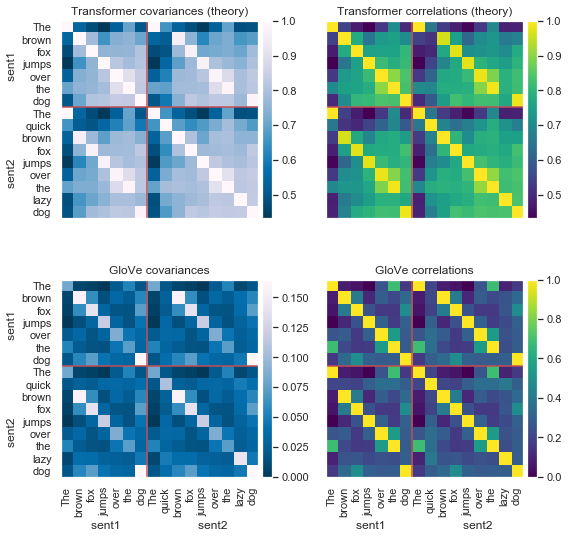

In [9]:
from utils import getCor, colorbar

plt.figure(figsize=(8, 8))

plt.subplot(221)
ax = plt.gca()
im_thcov = plt.imshow(theoryker, cmap='PuBu_r')
span = np.linspace(-.5, 15.5)
plt.plot(span, [6.5]*len(span), 'r')
plt.plot([6.5]*len(span), span, 'r')
plt.yticks(np.arange(16), sent1+sent2)
plt.xticks([])
plt.title('Transformer covariances (theory)')
plt.ylabel('sent2                       sent1')
plt.grid()
colorbar(im_thcov)

plt.subplot(222)
ax = plt.gca()
im_thcor = plt.imshow(getCor(theoryker), cmap='viridis')
span = np.linspace(-.5, 15.5)
plt.plot(span, [6.5]*len(span), 'r')
plt.plot([6.5]*len(span), span, 'r')
plt.yticks([])
plt.xticks([])
plt.title('Transformer correlations (theory)')
# plt.colorbar()
plt.grid()
colorbar(im_thcor)


plt.subplot(223)
ax = plt.gca()
im_glove = plt.imshow(exampleGloveCov, cmap='PuBu_r')
span = np.linspace(-.5, 15.5)
plt.plot(span, [6.5]*len(span), 'r')
plt.plot([6.5]*len(span), span, 'r')
plt.yticks(np.arange(16), sent1+sent2)
plt.xticks(np.arange(16), sent1+sent2, rotation=90)
plt.title('GloVe covariances')
plt.xlabel('sent1                       sent2')
plt.ylabel('sent2                       sent1')
plt.grid()
colorbar(im_glove)

plt.subplot(224)
ax = plt.gca()
im_glovecor = plt.imshow(getCor(exampleGloveCov), cmap='viridis')
span = np.linspace(-.5, 15.5)
plt.plot(span, [6.5]*len(span), 'r')
plt.plot([6.5]*len(span), span, 'r')
plt.yticks([])
plt.xticks(np.arange(16), sent1+sent2, rotation=90)
plt.title('GloVe correlations')
plt.xlabel('sent1                       sent2')
plt.grid()
colorbar(im_glovecor)

plt.tight_layout()

In [10]:
with open('transformer2layer.kernel', 'wb') as f:
    np.save(f, theoryker)

# Verify Theory with Simulations

We randomly initialize 100 transformers for each width among $[2^5, 2^6, \ldots, 2^{13}]$ and run them on the two sentences above.
We calculate the empirical Gram matrix of the transformer embeddings as well as its Frobenius distance to the infinite-width theoretical kernel `theoryker`.

In [11]:
widths = [2**i for i in range(5, 13)]
frobs = []
for d_h in widths:
    mytrfmr = Transformer(d_h, 300, 2)
    for _ in range(10):
        mytrfmr.randomize()
        outvecs1 = mytrfmr(exampleGloveVecs[:7])
        outvecs2 = mytrfmr(exampleGloveVecs[7:])
        outvecs = np.concatenate([outvecs1, outvecs2])
        outgram = outvecs @ outvecs.T / outvecs.shape[1]
        diff = outgram - theoryker
        frobs.append({
            "absfrob": np.linalg.norm(diff)**2,
            "relfrob": (np.linalg.norm(diff) / np.linalg.norm(theoryker))**2,
            "width": d_h
        })

We store the results in a dataframe `frob_df`.

In [12]:
frob_df = pd.DataFrame(frobs)

In [13]:
frob_df.to_pickle('transformer2layer.df')

The deviation from infinite-width theory drops with width, as expected.

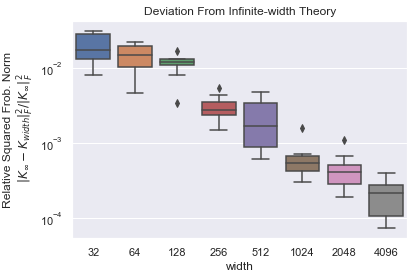

In [14]:
sns.boxplot(x='width', y='relfrob', data=frob_df)
plt.semilogy()
# plt.legend()
plt.title('Deviation From Infinite-width Theory')
_ = plt.ylabel(u'Relative Squared Frob. Norm\n $\|K_{\infty} - K_{width}\|_F^2/\|K_{\infty}\|_F^2$')

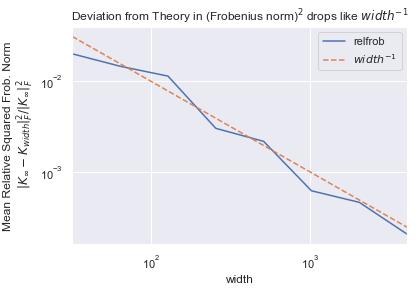

In [15]:
frob_df.groupby('width', as_index=False).mean().plot.line(x='width', y='relfrob')
plt.plot(widths, np.array(widths, dtype='float')**-1, '--', label=u'${width}^{-1}$')
plt.ylabel(u'Mean Relative Squared Frob. Norm\n $\|K_{\infty} - K_{width}\|_F^2/\|K_{\infty}\|_F^2$')
plt.loglog()
plt.legend()
_ = plt.title(u'Deviation from Theory in (Frobenius norm)$^2$ drops like $width^{-1}$')